In [5]:
# import libraries
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [6]:
class Event:

    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp # time within simulation
        self.function = function # function to call when event triggered
        self.args = args # list of values sent
        self.kwargs = kwargs # for keyword arguments --> unwrap as dictionary

    def __lt__(self, other):
        return self.timestamp < other.timestamp

    def run(self, schedule):
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:

    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush( self.priority_queue, Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [117]:
class VizSchedule(Schedule):
    
    '''
    Inherit from Schedule to create a visual representation of the scheduler
    '''
    
    def __init__(self):
        super().__init__()
        self.event_count = 0
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        Change the function to create a plot every time an event is created.
        '''
        if function.__name__ != "serve":
            x = [self.now, self.now+interval]
            y = [self.event_count, self.event_count]
            if function.__name__ == "end_serve":
                plt.plot(x, y, color="green")
            elif function.__name__ == "arrive":
                plt.plot(x, y, color="grey")
        else:
            pass
            #plt.plot([self.now],[self.event_count], marker="o", markersize=10, markerfacecolor="red", markeredgecolor="none")
        self.add_event_at(self.now + interval, function, *args, **kwargs)
        self.event_count += 1

In [118]:
class Queue:
    
    ''' Create a queue for the store, where people can arrive and get served.
    '''
    
    def __init__(self, store, id):
    
        self.store = store
        self.id = id
        self.in_queue = 0
        self.served = 0
        self.serving = False
        
    def arrive(self, schedule):
        #print(f"A customer has arrived @ {schedule.now}")
        self.in_queue += 1
        
    def end_serve(self, schedule):
        #print(f"Finished serving a customer @ {schedule.now}")
        self.served += 1
        self.serving = False
        store.schedule.add_event_after(0, self.serve)
        
    def serve(self, _):
        if self.in_queue > 0 and not self.serving:
            #print(f"Starting to serve a customer @ {schedule.now}")
            self.in_queue -= 1
            self.serving = True
            interval = store.service_time
            store.schedule.add_event_after(interval, self.end_serve)
            
    def run(self):
        interval = store.arrival_distribution.rvs()
        store.schedule.add_event_after(interval, self.arrive) 
        self.serve(_)
        store.schedule.run_next_event()

class GroceryStore:
    
    '''
    Create a class for the grocery store that takes into account the constants.
    And runs the simulation
    '''
    
    def __init__(self, arrival_rate, service_time, queue_num):
        
        self.schedule = VizSchedule()
        self.queues = [Queue(self, str(i)) for i in range(queue_num)]
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)
        self.service_time = service_time
        
    def generate_report(self):
        print("Generating report")
        print("- - - - - - - ")
        print("- - - - - - - ")
        for queue in self.queues:
            print(f"Queue ID: {queue.id}")
            print("- - - - - - - ")
            print(f"Customers in queue: {queue.in_queue}")
            print(f"Customers served: {queue.served}")
        
    def run(self, simulation_duration):
        
        '''
        Run the simulation until the duration is reached.
        Generate a report once the simulation ends.
        '''
        
        while self.schedule.now < simulation_duration:
            for queue in self.queues:
                queue.run()
                
        self.generate_report()
        

Generating report
- - - - - - - 
- - - - - - - 
Queue ID: 0
- - - - - - - 
Customers in queue: 919
Customers served: 9


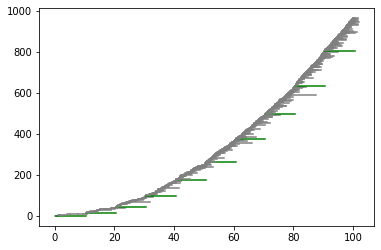

In [125]:
store = GroceryStore(1,10,1)
store.run(100)

## Analysis

### Python Implementation
Althouh the code implements a simulation, I must add the appropriate unit tests to ensure the simulation is running according to plan. Although we are using a heap, we store the values as a list, which makes it inefficient to run it continuously given we must keep heapifying our list. The visualization is also poor. Although it captures when customer is being served, it is missing labels to tell what is going on. It would also be helpful to plot not the # of total events, but how this relates to the queue length.

### Code Readabiity
The readability of the code is also poor. Commenting the code is not used and although we use variables rather than numbers, we could do a better job at architecting a more straight-forward and organized implementation. For example, the constants for mu and lambda should get switched whenever we want to have a MM1 rather than MD1 query.